# **Módulo 3: Introdução à aprendizagem profunda com PyTorch**

## Introdução
Nos *notebooks* anteriores, criamos, treinamos e avaliamos redes neurais usando classes de Python que desenvolvemos. Existem muitas bibliotecas de código aberto que ajudam a otimizar e tornar o processo de criação desses modelos repetível. Neste *notebook*, vamos analisar uma das mais populares: o PyTorch.

Após conhecermos, no *notebook* anterior, os conceitos básicos do uso de tensores no [Pytorch](https://pytorch.org/), vamos usá-los para criar modelos de aprendizagem profunda. No próximo *notebook*, passaremos por um exemplo de criação de um modelo de classificação e um modelo de regressão no PyTorch utilizando um grande conjunto de dados disponível publicamente.

## Classificação com PyTorch

Neste primeiro exemplo, usaremos o PyTorch para realizar uma tarefa de classificação binária em um conjunto de dados de código aberto. O conjunto de dados em questão é o conjunto de dados de idade de abalones e pode ser encontrado [aqui](https://archive.ics.uci.edu/dataset/1/abalone).

[Abalone](https://en.wikipedia.org/wiki/Abalone) é um tipo de molusco marinho e sua idade pode ser determinada por meio de uma tarefa extremamente manual de contagem de anéis dentro de sua concha. Esse conjunto de dados contém várias medidas que podem ser usadas para prever o número de anéis.

### Download do conjunto de dados e importação de módulos

In [1]:
# Faça o download dos arquivos .csv dos abalones a partir do arquivo de dados, se necessário.
!rm abalone.data abalone.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names

--2023-12-18 23:01:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘abalone.data’

abalone.data            [  <=>               ] 187.38K   341KB/s    in 0.5s    

2023-12-18 23:01:52 (341 KB/s) - ‘abalone.data’ saved [191873]

--2023-12-18 23:01:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘abalone.names’

abalone.names           [ <=>                ]   4.22K  --.-KB/s    in 0.001s  

2023-12-18 23:01:53 (7.91 MB/s) - ‘abalone.names’ saved 

In [2]:
#pip install torchvision

In [3]:
# Como você pode ver, agora precisamos de vários módulos diferentes
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time, copy

### Preparar os dados dos abalones para classificação

Queremos criar um problema de classificação para diferenciar abalones jovens (young) e adultos (old). Consideraremos qualquer abalone com menos de 10 anéis como jovem e todos os outros como adultos.

In [58]:

column_names = ["Sex", "Length", "Diameter", "Height", "Whole weight",
                "Shucked weight", "Viscera weight", "Shell weights", "Rings"]
df = pd.read_csv('abalone.data', header=None, names=column_names)
df['Old'] = 0  # Por padrão, o abalone é considerado jovem
df.loc[(df['Rings'] >= 10), 'Old'] = 1 # 10 anéis ou mais significa que um abalone é considerado adulto
class_labels = ['Young', 'Old']   # [0, 1], [N, P]
numerical_feature_columns = column_names[1:5] # Primeiramente, queremos classificar apenas com atributos numéricos, excluindo o sexo e considerando apenas o peso total
print(numerical_feature_columns)
label_column = 'Old'


df.head() # Visualizar um subconjunto do conjunto de dados

teste = type(df)
teste

['Length', 'Diameter', 'Height', 'Whole weight']


pandas.core.frame.DataFrame

### Divisão e padronização de treinamento/validação/teste

Para esta tarefa de classificação, dividiremos nosso conjunto de dados em três subconjuntos diferentes, conforme descrito anteriormente no módulo. O subconjunto de treinamento, o maior, será usado para treinar e otimizar os pesos do modelo. Em seguida, temos o subconjunto de validação, que será usado como uma avaliação imparcial do modelo e ajudará a ajustar diferentes hiperparâmetros. Por fim, temos o subconjunto de teste, usado para uma avaliação imparcial do modelo totalmente treinado.

Além disso, gostaríamos de realizar a padronização dos dados removendo a média e dimensionando pela variância. Faremos isso em cada um dos atributos, mas queremos garantir que essa função de padronização seja calculada no subconjunto de dados de treinamento. Em seguida, aplicamos a função de padronização aos conjuntos de validação e teste. Ao garantir que a padronização seja calculada apenas no subconjunto de treinamento, nos asseguramos que nenhuma informação dos conjuntos de validação ou teste esteja vazando para o subconjunto de treinamento.

Abaixo, fornecemos uma função para dividir um determinado conjunto de dados em treinamento/validação/teste, sendo 60/20/20, e executar a padronização de dados usando a classe StandardScaler do sklearn para consumo do PyTorch:

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def train_test_val_split(df, feature_columns, label_column, ct):
  # Primeiro, realizar uma divisão de treinamento/teste de 80/20
  initial_train_split = df.sample(frac=.8,random_state=42)
  test = df.drop(initial_train_split.index)

  # Em seguida, realizar uma divisão de treinamento/validação de 75/25
  train = initial_train_split.sample(frac=.75, random_state=42)
  val = initial_train_split.drop(train.index)

  # Separar todos os conjuntos de dados em atributos e rótulos (x e y)
  train_x = train[feature_columns]
  # Não será realizada transformação nos rótulos, então podem ser convertidos diretamente em tensores torch
  train_y = torch.from_numpy(train[label_column].values)

  val_x = val[feature_columns]
  val_y = torch.from_numpy(val[label_column].values)

  test_x = test[feature_columns]
  test_y = torch.from_numpy(test[label_column].values)

  # Ajustar o ColumnTransformer ao conjunto de dados de treinamento
  ct.fit(train_x)

  # Realizar a padronização em cada um dos conjuntos de dados x
  train_x = ct.transform(train_x)
  val_x = ct.transform(val_x)
  test_x = ct.transform(test_x)

  # Transformar nossos conjuntos de dados em tensores torch
  train_x = torch.from_numpy(train_x).float()
  val_x = torch.from_numpy(val_x).float()
  test_x = torch.from_numpy(test_x).float()

  # Criar os conjuntos de dados de entrada-rótulo para serem consumidos pelo PyTorch
  train_dataset = TensorDataset(train_x, train_y)
  test_dataset = TensorDataset(test_x, test_y)
  val_dataset = TensorDataset(val_x, val_y)
  return train_dataset, test_dataset, val_dataset


In [62]:
# Criar nosso StandardScaler para ser usado na padronização dos dados
# Mais informações aqui: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

train_dataset, test_dataset, val_dataset = train_test_val_split(df, numerical_feature_columns, label_column, ct)

### Hiperparâmetros do modelo e definição
Agora que podemos dividir facilmente nosso conjunto de dados em subconjuntos de treinamento, validação e teste, voltamos para a seleção de nossos hiperparâmetros. Esses hiperparâmetros incluem decisões de arquitetura do modelo (número de camadas ocultas) e parâmetros externos de treinamento, como tamanho do lote, taxa de aprendizado e número de épocas de treinamento.

In [7]:
# Configuração do dispositivo (treinar nosso modelo na GPU se estiver disponível, o que é muito mais rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparâmetros

# Arquitetura do modelo
input_size = len(numerical_feature_columns) # Garantir a remoção da coluna de index
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2

# Parâmetros externos de treinamento
batch_size = 10
learning_rate = 0.001
num_epochs = 50


### Seleção de hiperparâmetros

Neste passo a passo, usaremos nosso conjunto de validação para determinar dois hiperparâmetros diferentes.

O primeiro é o número total de épocas de treinamento. No final de todo o processo de treinamento, selecionaremos os pesos da época com a maior precisão de validação.

O segundo é o número de camadas. Vamos testar tanto uma rede com 2 camadas ocultas quanto uma com 3 camadas ocultas. Novamente, aquela que tiver o melhor desempenho no conjunto de validação será nosso modelo final escolhido.

In [8]:
# Modelo de classificação simples com duas camadas ocultas
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Modelo de classificação simples com três camadas ocultas
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
print(input_size) #Parametros de entrada
print(hidden_size1) #Parametros na primeira camada escondida
print(hidden_size2) #Parametros na segunda camada escondida
print(num_classes) #Parametros classificatorios de saida

4
64
64
2


In [10]:
two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(two_layer_model)

three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)
SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Preparação final dos dados

Agora que temos nosso modelo e nossos hiperparâmetros definidos, podemos realizar a última etapa de preparação dos dados. Vamos usar uma classe incorporada do PyTorch chamada DataLoader, com nosso tamanho de lote especificado anteriormente. Esse DataLoader será responsável por fornecer os lotes de dados ao modelo durante o treinamento.

In [11]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size),
               'val': DataLoader(val_dataset, batch_size=batch_size),
               'test': DataLoader(test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


In [12]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f3818d71bd0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f3818eb9690>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f3818e4d5d0>}

### Treinando o modelo

Agora que temos nossa arquitetura do modelo definida e nossos dados prontos para uso, precisamos definir a função de treinamento. Essa função será responsável por atualizar todos os pesos do modelo.

In [13]:
# De https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Manter os melhores pesos armazenados separadamente
    best_acc = 0.0
    best_epoch = 0

    # Cada época tem uma fase de treinamento, validação e teste
    phases = ['train', 'val', 'test']

    # Acompanhar a evolução da perda e da precisão durante o treinamento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Definir o modelo para o modo de treinamento
            else:
                model.eval()   # Definir o modelo para o modo de avaliação

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre os dados
            for inputs, labels in dataloaders[phase]:
                # Isso garante que todos os nossos pontos de dados sejam nivelados
                # antes de alimentá-los em nosso modelo
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zerar os gradientes dos parâmetros
                optimizer.zero_grad()

                # Propagação (forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Retropropagação (backward) + atualizar pesos somente se estiver na fase de treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Copiar profundamente o modelo se ele tiver a melhor precisão (com base na validação)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Carregar os pesos do melhor modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves

Escrevemos nossa função de treinamento acima para ser independente da arquitetura. Isso significa que podemos usar a mesma função para treinar as redes de duas camadas ocultas e de três camadas ocultas.

In [14]:
# Treinamento com duas camadas ocultas
# Perda e otimizador
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss para classificação!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Treinar o modelo. Também armazenaremos os resultados do treinamento para visualização
two_layer_model, training_curves_two_layer = train_model(two_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5338 Acc: 0.7334
val   Loss: 0.4636 Acc: 0.7703
test  Loss: 0.5292 Acc: 0.7198

Epoch 2/50
----------
train Loss: 0.5206 Acc: 0.7374
val   Loss: 0.4584 Acc: 0.7763
test  Loss: 0.5259 Acc: 0.7210

Epoch 3/50
----------
train Loss: 0.5164 Acc: 0.7402
val   Loss: 0.4567 Acc: 0.7787
test  Loss: 0.5254 Acc: 0.7234

Epoch 4/50
----------
train Loss: 0.5130 Acc: 0.7422
val   Loss: 0.4551 Acc: 0.7835
test  Loss: 0.5251 Acc: 0.7234

Epoch 5/50
----------
train Loss: 0.5098 Acc: 0.7414
val   Loss: 0.4546 Acc: 0.7931
test  Loss: 0.5249 Acc: 0.7257

Epoch 6/50
----------
train Loss: 0.5081 Acc: 0.7418
val   Loss: 0.4548 Acc: 0.7895
test  Loss: 0.5249 Acc: 0.7234

Epoch 7/50
----------
train Loss: 0.5068 Acc: 0.7442
val   Loss: 0.4542 Acc: 0.7847
test  Loss: 0.5247 Acc: 0.7186

Epoch 8/50
----------
train Loss: 0.5058 Acc: 0.7462
val   Loss: 0.4538 Acc: 0.7871
test  Loss: 0.5247 Acc: 0.7174

Epoch 9/50
----------
train Loss: 0.5047 Acc: 0.7466
val   Loss: 0.4548

Para determinar o peso que gostaríamos de usar em nosso modelo final, procuraremos a época que teve o melhor desempenho no conjunto de validação.

In [15]:
# Treinamento com três camadas ocultas
# perda e otimizador
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Treinar o modelo. Também armazenaremos os resultados do treinamento para visualização
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5394 Acc: 0.7338
val   Loss: 0.4603 Acc: 0.7691
test  Loss: 0.5290 Acc: 0.7162

Epoch 2/50
----------
train Loss: 0.5221 Acc: 0.7398
val   Loss: 0.4566 Acc: 0.7763
test  Loss: 0.5275 Acc: 0.7210

Epoch 3/50
----------
train Loss: 0.5149 Acc: 0.7398
val   Loss: 0.4527 Acc: 0.7823
test  Loss: 0.5270 Acc: 0.7281

Epoch 4/50
----------
train Loss: 0.5105 Acc: 0.7442
val   Loss: 0.4509 Acc: 0.7919
test  Loss: 0.5270 Acc: 0.7329

Epoch 5/50
----------
train Loss: 0.5088 Acc: 0.7466
val   Loss: 0.4503 Acc: 0.7907
test  Loss: 0.5261 Acc: 0.7293

Epoch 6/50
----------
train Loss: 0.5065 Acc: 0.7470
val   Loss: 0.4496 Acc: 0.7955
test  Loss: 0.5260 Acc: 0.7281

Epoch 7/50
----------
train Loss: 0.5048 Acc: 0.7482
val   Loss: 0.4491 Acc: 0.7967
test  Loss: 0.5254 Acc: 0.7269

Epoch 8/50
----------
train Loss: 0.5034 Acc: 0.7510
val   Loss: 0.4489 Acc: 0.7967
test  Loss: 0.5252 Acc: 0.7186

Epoch 9/50
----------
train Loss: 0.5019 Acc: 0.7510
val   Loss: 0.4483

Após nosso treinamento, observamos uma precisão comparável entre nossos dois modelos diferentes, portanto, usaremos o modelo de três camadas daqui para frente, mas exploraremos outros métodos para melhorar nosso desempenho.

### Métricas e curvas de treinamento

Abaixo, fornecemos funções para visualizar as curvas de treinamento e as métricas do problema de classificação. Sinta-se à vontade para usar essas funções no futuro!

In [16]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Definir o modelo no modo de avaliação
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_regression(model, device, dataloader):
    preds, targets = regress_predictions(model, device, dataloader)
    plt.figure()
    plt.title(f'Regression results')
    plt.scatter(targets, preds)
    xmin = min(min(targets), min(preds))
    xmax = max(max(targets), max(targets))
    plt.plot([xmin, xmax], [xmin, xmax], 'black', linestyle='--', marker='')
    plt.xlabel('target value')
    plt.ylabel('prediced value')

def regress_predictions(model, device, dataloader):
    model.eval()   # Definir o modelo no modo de avaliação
    all_targets = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        all_targets = torch.cat((all_targets, targets), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_targets.detach().cpu()

def plot_metrics(model, device, dataloaders, phase='test'):
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    auc = metrics.roc_auc_score(labels, preds)

    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
    ind = np.argmin(np.abs(thresholds - 0.5))
    ax = disp.plot().ax_
    ax.scatter(fpr[ind], tpr[ind], color = 'red')
    ax.set_title('ROC Curve (red dot at threshold = 0.5)')

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    #disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

    ncm = metrics.confusion_matrix(labels, preds, normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=ncm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- rates')

    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    N, P = TN + FP, TP + FN
    ACC = (TP + TN)/(P+N)
    TPR, FPR, FNR, TNR = TP/P, FP/N, FN/P, TN/N
    print(f'\nAt default threshold:')
    print(f' TN = {TN:5},  FP = {FP:5} -> N = {N:5}')
    print(f' FN = {FN:5},  TP = {TP:5} -> P = {P:5}')
    print(f'TNR = {TNR:5.3f}, FPR = {FPR:5.3f}')
    print(f'FNR = {FNR:5.3f}, TPR = {TPR:5.3f}')
    print(f'ACC = {ACC:6.3f}')

    return cm, fpr, tpr, thresholds, auc

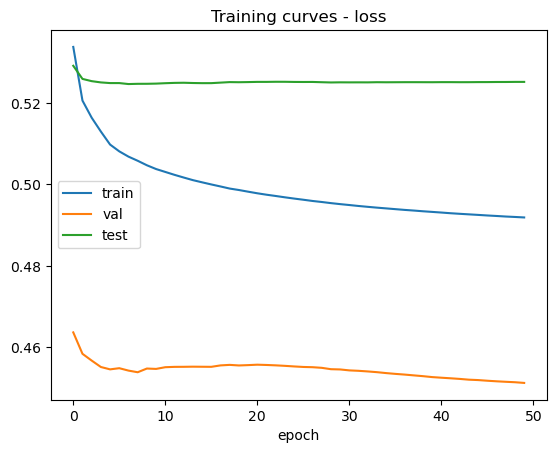

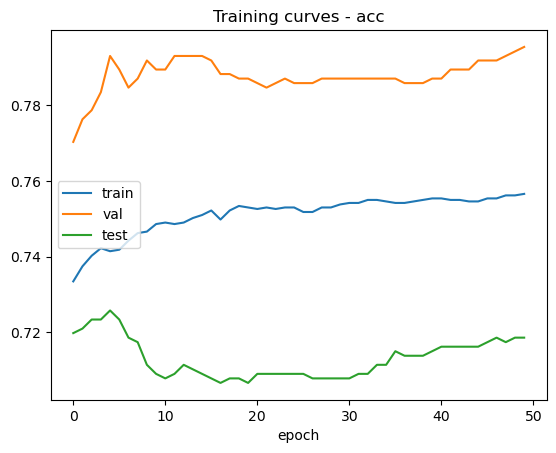

In [17]:
plot_training_curves(training_curves_two_layer, phases=['train', 'val', 'test'])

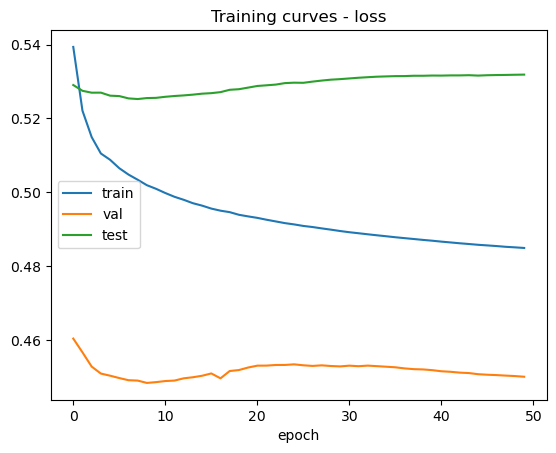

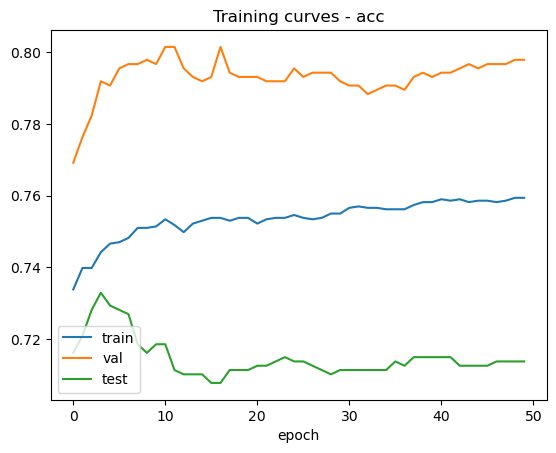

In [18]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

Observando esse gráfico, podemos ver que nosso modelo está se sobreajustando ao conjunto de dados de treinamento. Como nossa curva de treinamento azul (perda) está diminuindo constantemente, na verdade vemos que a perda de validação aumenta. Vamos resolver o problema do sobreajuste nas próximas seções.


At default threshold:
 TN =   263,  FP =   138 -> N =   401
 FN =    97,  TP =   337 -> P =   434
TNR = 0.656, FPR = 0.344
FNR = 0.224, TPR = 0.776
ACC =  0.719


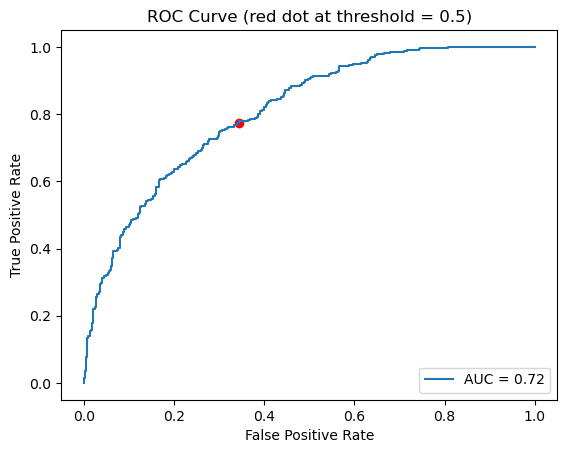

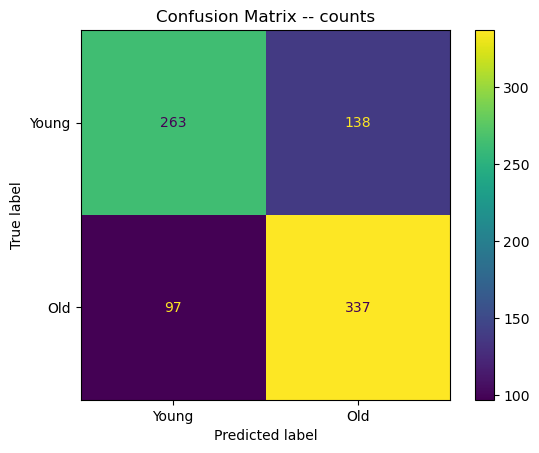

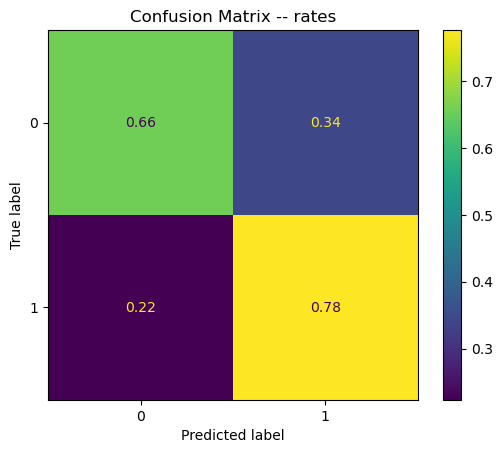

In [19]:
res = plot_metrics(three_layer_model, device, dataloaders, phase='test')

Aqui, podemos ver a curva ROC e a matriz de confusão que foram abordadas no módulo. Parece que nosso modelo está prevendo incorretamente um abalone jovem como abalone adulto em uma taxa maior do que vice-versa.

## Recursos adicionais
Para a primeira rodada de seleção de atributos, optamos por usar apenas recursos numéricos. No entanto, estamos perdendo algumas informações importantes sobre os abalones ao não incluir seu sexo em nosso modelo. Para traduzir esse recurso ternário de nosso conjunto de dados para o modelo, usaremos a codificação one-hot. Agora, criaremos um atributo para cada uma das opções diferentes e atribuiremos o valor 1 se a amostra for um membro dessa classe e 0 para as outras. As estratégias de codificação podem ser simples, como esse método one-hot, ou podem ser muito mais complexas, como aprenderemos mais adiante no curso.

In [20]:
# Inserir os novos atributos de codificação one-hot
encoded_df = df.copy(True)
encoded_df.insert(1, 'M', 0)
encoded_df.insert(1, 'F', 0)
encoded_df.insert(1, 'I', 0)
encoded_df.loc[(df['Sex'] == 'M'), 'M'] = 1
encoded_df.loc[(df['Sex'] == 'F'), 'F'] = 1
encoded_df.loc[(df['Sex'] == 'I'), 'I'] = 1
encoded_column_names = column_names[:]
encoded_column_names.insert(1,"M")
encoded_column_names.insert(1,"F")
encoded_column_names.insert(1,"I")
encoded_df.head()

,Sex,I,F,M,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,1,0,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


In [21]:
encoded_feature_columns = encoded_column_names[1:8]
print(encoded_feature_columns)
label_column = 'Old'

df.head()

['I', 'F', 'M', 'Length', 'Diameter', 'Height', 'Whole weight']


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


### Divisão de treinamento-validação-teste e padronização

Novamente, queremos realizar uma divisão de treinamento-validação-teste em nosso conjunto de dados. No entanto, queremos garantir que não realizemos a padronização em nossos novos atributos que são codificações one-hot!

In [22]:
# Aqui, usaremos o ColumnTransformer novamente para realizar a padronização dos dados. No entanto, estamos realizando essa padronização apenas nos atributos numéricos,
# NÃO nos atributos codificados em one-hot, então especificamos isso no construtor do ColumnTransformer.
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

encoded_train_dataset, encoded_test_dataset, encoded_val_dataset = train_test_val_split(encoded_df, encoded_feature_columns, label_column, ct)

### Definição e hiperparâmetros do modelo

In [23]:
# Configuração do dispositivo (treinar nosso modelo na GPU se estiver disponível, o que é muito mais rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparâmetros

input_size = len(encoded_feature_columns) # Garantir que nosso tamanho de entrada inclua os novos atributos
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2

# Parâmetros externos de treinamento
batch_size = 10
learning_rate = 0.001
num_epochs = 50


In [24]:
three_layer_encoded_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_encoded_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Preparação de dados finais

In [25]:
# Configurar conjuntos de dados e DataLoaders do Pytorch

dataloaders = {'train': DataLoader(encoded_train_dataset, batch_size=batch_size),
               'val': DataLoader(encoded_val_dataset, batch_size=batch_size),
               'test': DataLoader(encoded_test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(encoded_train_dataset),
                 'val': len(encoded_val_dataset),
                 'test': len(encoded_test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


In [26]:
# Perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_layer_encoded_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_model, training_curves_three_layer_encoded = train_model(three_layer_encoded_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5268 Acc: 0.7370
val   Loss: 0.4417 Acc: 0.7835
test  Loss: 0.5085 Acc: 0.7186

Epoch 2/50
----------
train Loss: 0.5058 Acc: 0.7394
val   Loss: 0.4370 Acc: 0.8002
test  Loss: 0.5048 Acc: 0.7198

Epoch 3/50
----------
train Loss: 0.5008 Acc: 0.7442
val   Loss: 0.4363 Acc: 0.7943
test  Loss: 0.5046 Acc: 0.7257

Epoch 4/50
----------
train Loss: 0.4971 Acc: 0.7466
val   Loss: 0.4362 Acc: 0.7919
test  Loss: 0.5044 Acc: 0.7317

Epoch 5/50
----------
train Loss: 0.4933 Acc: 0.7490
val   Loss: 0.4349 Acc: 0.7967
test  Loss: 0.5043 Acc: 0.7293

Epoch 6/50
----------
train Loss: 0.4902 Acc: 0.7510
val   Loss: 0.4340 Acc: 0.7990
test  Loss: 0.5042 Acc: 0.7281

Epoch 7/50
----------
train Loss: 0.4887 Acc: 0.7526
val   Loss: 0.4338 Acc: 0.8002
test  Loss: 0.5042 Acc: 0.7293

Epoch 8/50
----------
train Loss: 0.4871 Acc: 0.7542
val   Loss: 0.4336 Acc: 0.7990
test  Loss: 0.5041 Acc: 0.7293

Epoch 9/50
----------
train Loss: 0.4857 Acc: 0.7546
val   Loss: 0.4333

Ao incluir esses novos atributos, observamos pouca mudança em nosso desempenho geral, o que indica que esses novos atributos não estão oferecendo um ganho significativo de informações.

### Curvas de treinamento e métricas

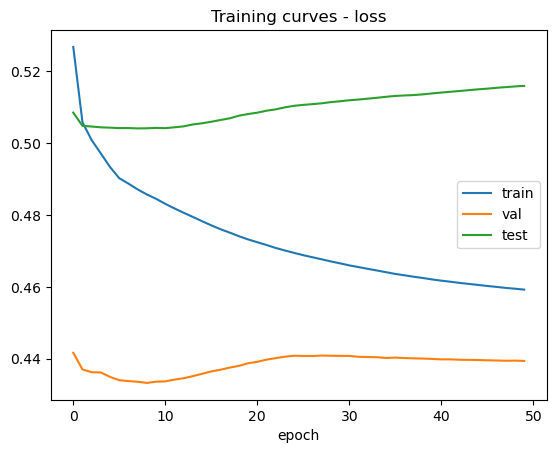

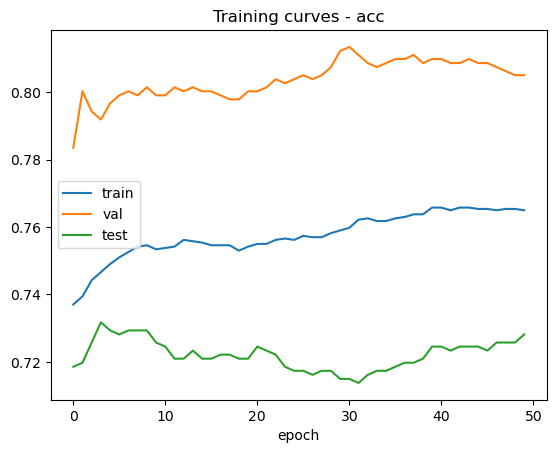

In [27]:
plot_training_curves(training_curves_three_layer_encoded, phases=['train', 'val', 'test'])

Além disso, parece que nosso modelo ainda está se sobreajustando ao conjunto de dados com base nesses gráficos.


At default threshold:
 TN =   261,  FP =   140 -> N =   401
 FN =    98,  TP =   336 -> P =   434
TNR = 0.651, FPR = 0.349
FNR = 0.226, TPR = 0.774
ACC =  0.715


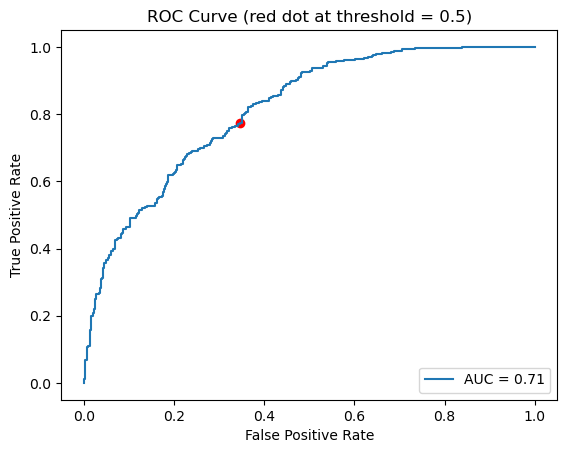

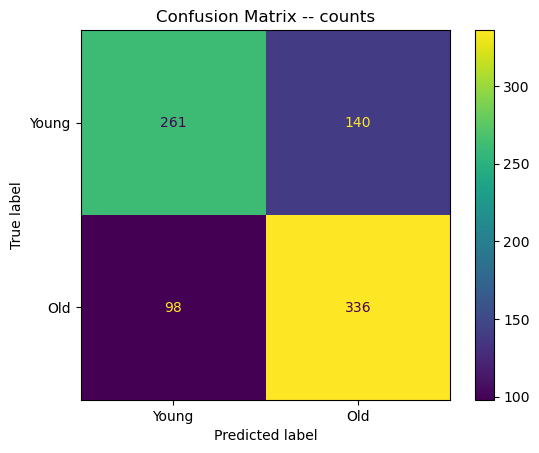

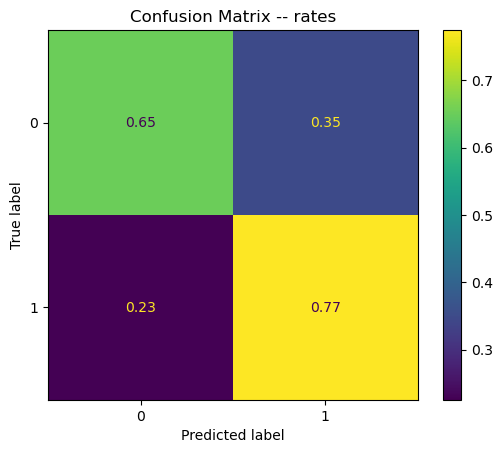

In [28]:
res = plot_metrics(three_layer_encoded_model, device, dataloaders, phase='test')

## Regularização e *dropout*

Um dos principais assuntos abordados neste módulo foram os métodos para evitar o sobreajuste. Ao analisar os gráficos de treinamento acima, podemos ver que o modelo teve um sobreajuste significativo ao conjunto de dados de treinamento. Para combater isso, temos algumas ferramentas à nossa disposição.

O PyTorch possui dois dos métodos que discutimos, regularização e *dropout*, incorporados. Vamos examinar como ambos afetam o desempenho do modelo.

# Regularização: 
Evita que os pesos sejam muito altos, para que o modelo não fique "Super treinado" aos dados apresentados.

# DropOut: 
Desliga um neuronio aleatorio durante as epocas de treinamento, para evitar que os demais sejam super dependentes do mesmo.

### Regularização

In [29]:
# Redefinir o modelo
three_layer_encoded_l2_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes).to(device)
print(three_layer_encoded_l2_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [30]:
# Perda e otimizador
criterion = nn.CrossEntropyLoss()
# Ao adicionar um termo weight_decay ao otimizador, estamos incluindo a regularização L2
optimizer = torch.optim.Adam(three_layer_encoded_l2_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_model, training_curves_three_layer_encoded_l2 = train_model(three_layer_encoded_l2_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5354 Acc: 0.7334
val   Loss: 0.4569 Acc: 0.7787
test  Loss: 0.5212 Acc: 0.7234

Epoch 2/50
----------
train Loss: 0.5143 Acc: 0.7418
val   Loss: 0.4540 Acc: 0.7811
test  Loss: 0.5177 Acc: 0.7222

Epoch 3/50
----------
train Loss: 0.5116 Acc: 0.7434
val   Loss: 0.4535 Acc: 0.7823
test  Loss: 0.5165 Acc: 0.7281

Epoch 4/50
----------
train Loss: 0.5100 Acc: 0.7438
val   Loss: 0.4533 Acc: 0.7859
test  Loss: 0.5160 Acc: 0.7281

Epoch 5/50
----------
train Loss: 0.5090 Acc: 0.7442
val   Loss: 0.4530 Acc: 0.7871
test  Loss: 0.5157 Acc: 0.7281

Epoch 6/50
----------
train Loss: 0.5081 Acc: 0.7450
val   Loss: 0.4528 Acc: 0.7883
test  Loss: 0.5152 Acc: 0.7281

Epoch 7/50
----------
train Loss: 0.5074 Acc: 0.7462
val   Loss: 0.4530 Acc: 0.7907
test  Loss: 0.5150 Acc: 0.7269

Epoch 8/50
----------
train Loss: 0.5068 Acc: 0.7466
val   Loss: 0.4530 Acc: 0.7907
test  Loss: 0.5148 Acc: 0.7269

Epoch 9/50
----------
train Loss: 0.5064 Acc: 0.7474
val   Loss: 0.4532

#### Métricas e curvas de treinamento

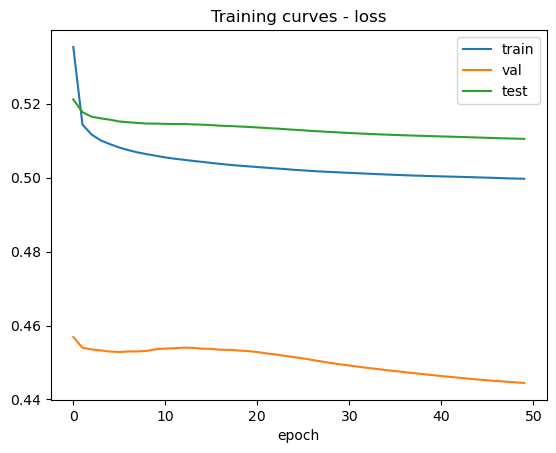

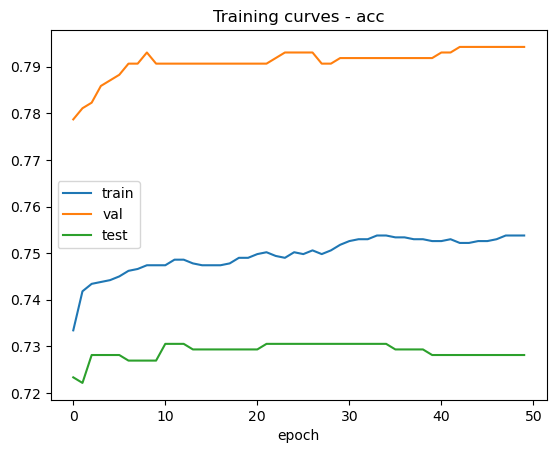

In [31]:
plot_training_curves(training_curves_three_layer_encoded_l2, phases=['train', 'val', 'test'])

Observando os gráficos acima, não vemos o mesmo comportamento de sobreajuste no conjunto de validação, mas ainda há outros métodos que podemos usar para melhorar ainda mais a generalização.


At default threshold:
 TN =   247,  FP =   154 -> N =   401
 FN =    73,  TP =   361 -> P =   434
TNR = 0.616, FPR = 0.384
FNR = 0.168, TPR = 0.832
ACC =  0.728


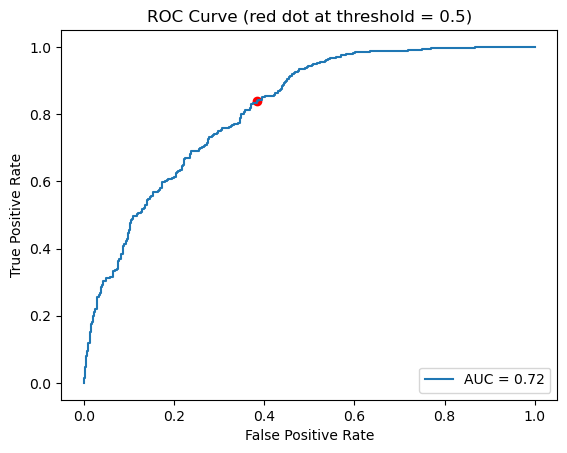

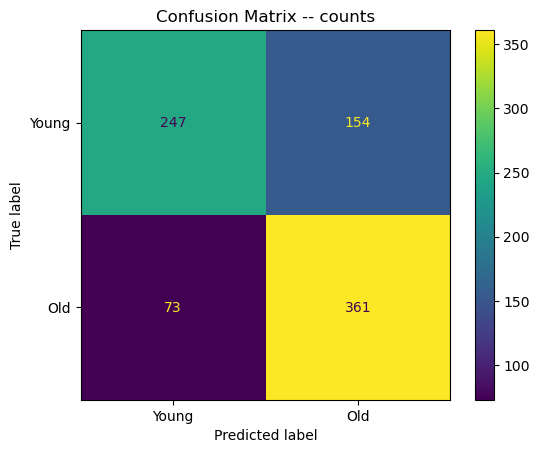

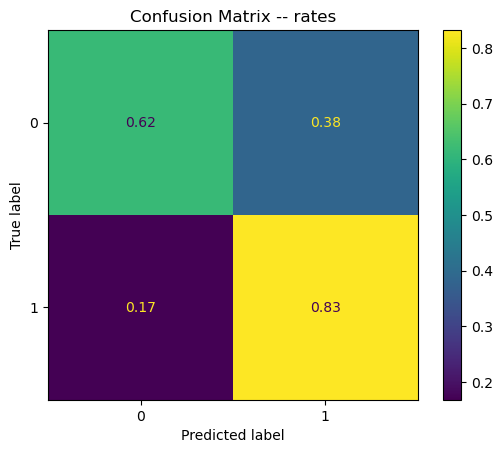

In [32]:
res = plot_metrics(three_layer_encoded_l2_model, device, dataloaders, phase='test')

TN (True Negatives): 248

O número de exemplos negativos corretamente classificados como negativo
s.
FP (False Positives): 53

O número de exemplos negativos incorretamente classificados como posit
ivos.
FN (False Negative): 73

O número de exemplos positivos incorretamente classificados como ne
gativos.
TP (True Posities): 361

O número de exemplos positivos corretamente classificados como
 positivos.
N (Total Negatives): 41 (TN + FP)

O total de exemp
los negativos.
P (Total Positives) 434 (FN + TP)

O total de ex
emplos positivos.
TNR (True Negative Rate ou Specificit): 0.618 (TN / N)

A proporção de exemplos negativos corretamente classificados em relação ao total de
 exemplos negativos.
FPR (False Positive ate): 0.382 (FP / N)

A proporção de exemplos negativos incorretamente classificados em relação ao total
 de exemplos negativos.
FNR (False Negative Rate ou Mis Rate): 0.168 (FN / P)

A proporção de exemplos positivos incorretamente classificados em relação ao to
tal de exemplos positivos.
TPR (True Positive Rate ou Sensitivityou Recall): 0.832 (TP / P)

A proporção de exemplos positivos corretamente classificados em relação ao
 total de exemplos positivos.
ACC (Accuracy: 0.729 ((TP + TN) / (P + N))

A acurácia geral do modelo, que é a proporção de exemplos corretamente classificados em relação ao total de exemplos.

### *Dropout*

In [33]:
# Configuração do dispositivo (treinar nosso modelo na GPU se estiver disponível, o que é muito mais rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparâmetros

# Arquitetura do modelo
input_size = len(encoded_feature_columns)
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2
dropout = .25

# Parâmetros externos de treinamento
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [34]:
# Modelo de classificação simples com três camadas ocultas e dropout
class SimpleClassifier3LayerDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3LayerDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # Taxa de dropout
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [35]:
# Redefinir o modelo com dropout
three_layer_encoded_l2_dropout_model = SimpleClassifier3LayerDropout(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes, dropout).to(device)
print(three_layer_encoded_l2_dropout_model)

SimpleClassifier3LayerDropout(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [36]:
# Perda e otimizador
criterion = nn.CrossEntropyLoss()
# Ao adicionar um termo weight_decay ao otimizador, estamos incluindo a regularização L2
optimizer = torch.optim.Adam(three_layer_encoded_l2_dropout_model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_dropout_model, training_curves_three_layer_encoded_l2_dropout = train_model(three_layer_encoded_l2_dropout_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5561 Acc: 0.7291
val   Loss: 0.4622 Acc: 0.7715
test  Loss: 0.5240 Acc: 0.7198

Epoch 2/50
----------
train Loss: 0.5244 Acc: 0.7454
val   Loss: 0.4596 Acc: 0.7799
test  Loss: 0.5210 Acc: 0.7257

Epoch 3/50
----------
train Loss: 0.5190 Acc: 0.7474
val   Loss: 0.4574 Acc: 0.7859
test  Loss: 0.5178 Acc: 0.7293

Epoch 4/50
----------
train Loss: 0.5165 Acc: 0.7454
val   Loss: 0.4618 Acc: 0.7871
test  Loss: 0.5200 Acc: 0.7257

Epoch 5/50
----------
train Loss: 0.5191 Acc: 0.7446
val   Loss: 0.4650 Acc: 0.7919
test  Loss: 0.5210 Acc: 0.7246

Epoch 6/50
----------
train Loss: 0.5187 Acc: 0.7434
val   Loss: 0.4582 Acc: 0.7919
test  Loss: 0.5186 Acc: 0.7210

Epoch 7/50
----------
train Loss: 0.5187 Acc: 0.7434
val   Loss: 0.4625 Acc: 0.7907
test  Loss: 0.5194 Acc: 0.7222

Epoch 8/50
----------
train Loss: 0.5144 Acc: 0.7422
val   Loss: 0.4610 Acc: 0.7907
test  Loss: 0.5190 Acc: 0.7234

Epoch 9/50
----------
train Loss: 0.5153 Acc: 0.7470
val   Loss: 0.4647

Nesse caso, incluir o *dropout* parece ter feito apenas uma pequena mudança em nossa precisão geral. Considerando que este é um modelo profundo relativamente simples (especialmente em comparação com algumas das redes focadas em visão que veremos no futuro), isso não é totalmente inesperado e o *dropout* pode não ser a melhor escolha para esse problema. No entanto, vamos investigar as curvas de treinamento abaixo.

#### Curvas de treinamento e métricas

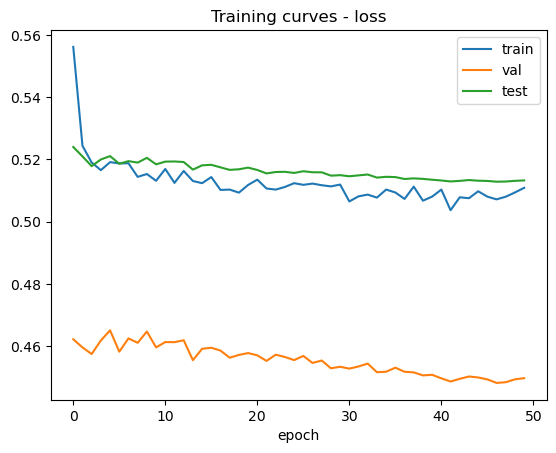

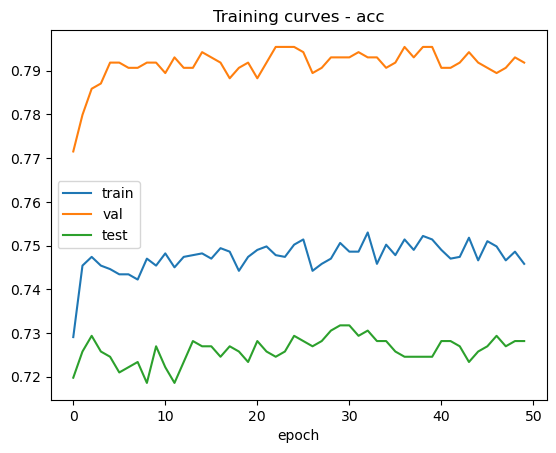

In [37]:
plot_training_curves(training_curves_three_layer_encoded_l2_dropout, phases=['train', 'val', 'test'])

Ao analisar essas curvas, podemos ver que incluir o *dropout* melhorou a generalização do nosso modelo e evitou o sobreajuste.


At default threshold:
 TN =   237,  FP =   164 -> N =   401
 FN =    66,  TP =   368 -> P =   434
TNR = 0.591, FPR = 0.409
FNR = 0.152, TPR = 0.848
ACC =  0.725


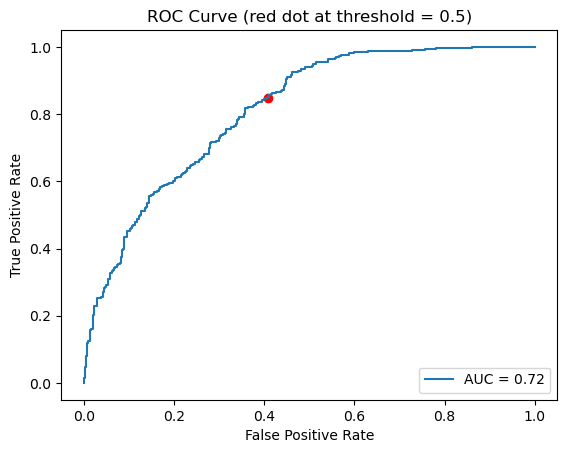

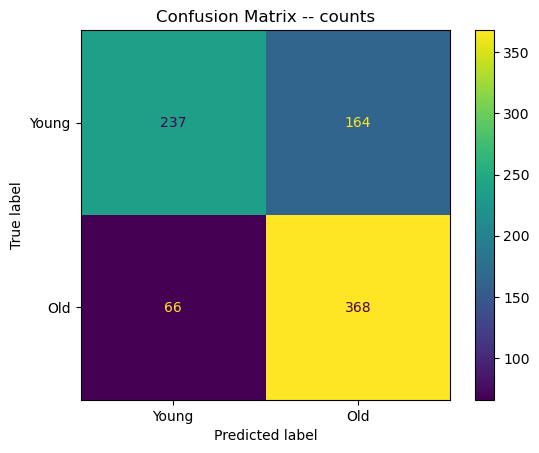

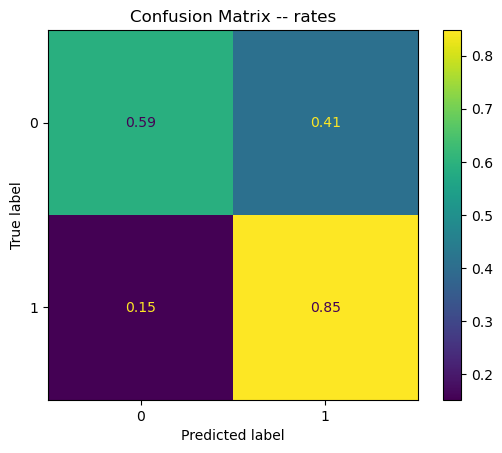

In [38]:
res = plot_metrics(three_layer_encoded_l2_dropout_model, device, dataloaders, phase='test')

## Modelo de Regressão
Agora, em vez de fazer apenas uma classificação binária para determinar se um abalone é jovem ou adulto, queremos prever o número exato de anéis. Podemos facilmente adaptar nosso modelo para realizar essa tarefa de regressão.

### Preparação do conjunto de dados

In [39]:
regression_label_column = 'Rings' # Alterar apenas a coluna de rótulo
# Rings (anéis) também precisa ser do tipo float, caso contrário, nossa função de perda não funcionará
encoded_df[regression_label_column] = encoded_df[regression_label_column].astype('float32')
encoded_df.dtypes

Sex                object
I                   int64
F                   int64
M                   int64
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weights     float64
Rings             float32
Old                 int64
dtype: object

### Divisão de treinamento-validação-teste e padronização

In [40]:
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

regression_train_dataset, regression_test_dataset, regression_val_dataset = train_test_val_split(encoded_df, encoded_feature_columns, regression_label_column, ct)

### Hiperparâmetros do modelo e definição

In [41]:
# Configuração do dispositivo (treinar nosso modelo na GPU se estiver disponível, o que é muito mais rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparâmetros

# Arquitetura do modelo
input_size = len(encoded_feature_columns)
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
output_neurons = 1
dropout = .25

# Parâmetros externos de treinamento
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [42]:
# Modelo de regressão simples de três camadas ocultas com dropout
class SimpleRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_neurons, dropout):
        super(SimpleRegressor, self).__init__()
        self.dropout = nn.Dropout(dropout) # Taxa de dropout
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, output_neurons),
        )

    def forward(self, x):
        return self.layers(x)

In [43]:
regression_model = SimpleRegressor(input_size, hidden_size1, hidden_size2, hidden_size3, output_neurons, dropout).to(device)
print(regression_model)

SimpleRegressor(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Preparação dos dados finais

In [44]:
# Configurar conjuntos de dados e DataLoaders do PyTorch

dataloaders = {'train': DataLoader(regression_train_dataset, batch_size=batch_size),
               'val': DataLoader(regression_val_dataset, batch_size=batch_size),
               'test': DataLoader(regression_test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(regression_train_dataset),
                 'val': len(regression_val_dataset),
                 'test': len(regression_test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


### Treinando o modelo

Vamos ajustar o procedimento de treinamento anterior para se adequar ao nosso problema de regressão.

In [45]:
# De https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_regression_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_epoch = 0

    # Cada época possui uma fase de treinamento, validação e teste
    phases = ['train', 'val', 'test']

    # Acompanhe como a perda e a precisão evoluem durante o treinamento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Definir o modelo no modo de treinamento
            else:
                model.eval()   # Definir o modelo no modo de avaliação

            running_loss = 0.0

            # Iterar sobre os dados
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device) #

                # Zerar os gradientes dos parâmetros
                optimizer.zero_grad()

                # Propagação (forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.flatten(model(inputs))
                    loss = criterion(outputs, targets)

                    # Retropropagação (backward) e atualização dos pesos apenas na fase de treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Realizar uma cópia profunda do modelo se for a melhor precisão (com base na validação)
            if phase == 'val' and epoch_loss < best_loss:
                best_epoch = epoch
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Carregar os melhores pesos do modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [46]:
# Perda e otimizador
criterion = nn.MSELoss() # Perda de MSE em vez de CrossEntropy
optimizer = torch.optim.Adam(regression_model.parameters(), lr=learning_rate,
                             weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

regression_model, training_curves_regression = train_regression_model(regression_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 27.4087
val   Loss: 7.1399
test  Loss: 6.2205

Epoch 2/50
----------
train Loss: 13.6789
val   Loss: 7.1684
test  Loss: 5.8112

Epoch 3/50
----------
train Loss: 12.4525
val   Loss: 6.6400
test  Loss: 5.8091

Epoch 4/50
----------
train Loss: 10.4399
val   Loss: 6.5115
test  Loss: 5.4975

Epoch 5/50
----------
train Loss: 9.6143
val   Loss: 6.4334
test  Loss: 5.4441

Epoch 6/50
----------
train Loss: 9.8669
val   Loss: 6.4147
test  Loss: 5.6217

Epoch 7/50
----------
train Loss: 9.1449
val   Loss: 6.3425
test  Loss: 5.4533

Epoch 8/50
----------
train Loss: 8.9769
val   Loss: 6.2786
test  Loss: 5.4169

Epoch 9/50
----------
train Loss: 8.8843
val   Loss: 6.3049
test  Loss: 5.3177

Epoch 10/50
----------
train Loss: 9.0424
val   Loss: 6.2986
test  Loss: 5.3101

Epoch 11/50
----------
train Loss: 8.7955
val   Loss: 6.3180
test  Loss: 5.2627

Epoch 12/50
----------
train Loss: 8.4755
val   Loss: 6.2903
test  Loss: 5.3563

Epoch 13/50
----------
train Los

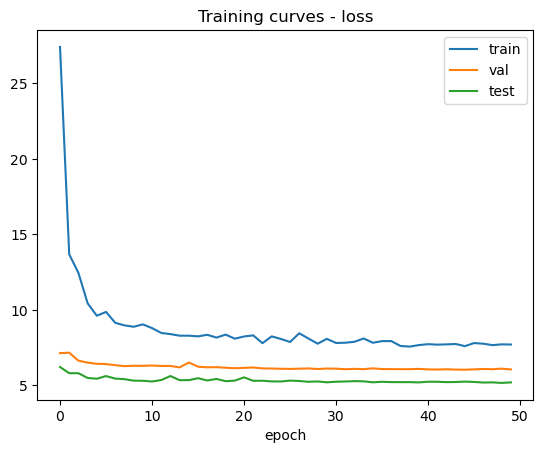

In [47]:
plot_training_curves(training_curves_regression, metrics=['loss'])

In [48]:
predicted_ages, true_ages = regress_predictions(regression_model, device, dataloaders['train'])
# Podemos ver que nossas previsões parecem sensatas em comparação com as idades dos abalones

In [49]:
predicted_ages

tensor([[10.7197],
        [ 7.7418],
        [10.9755],
        ...,
        [ 8.5583],
        [10.8575],
        [ 8.4422]])

In [50]:
true_ages

tensor([10.,  9.,  9.,  ...,  7., 14., 10.])

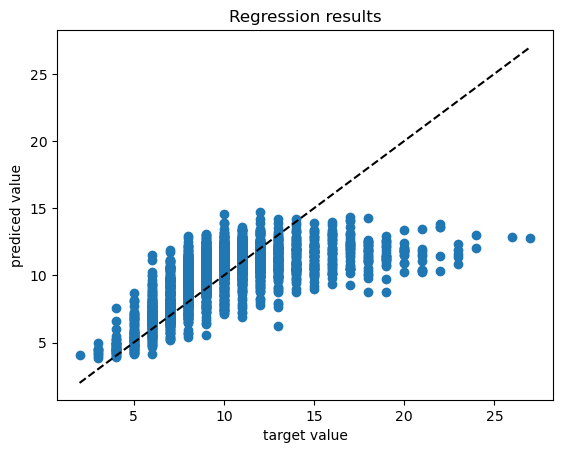

In [51]:
# Resultados do treinamento
plot_regression(regression_model, device, dataloaders['train'])

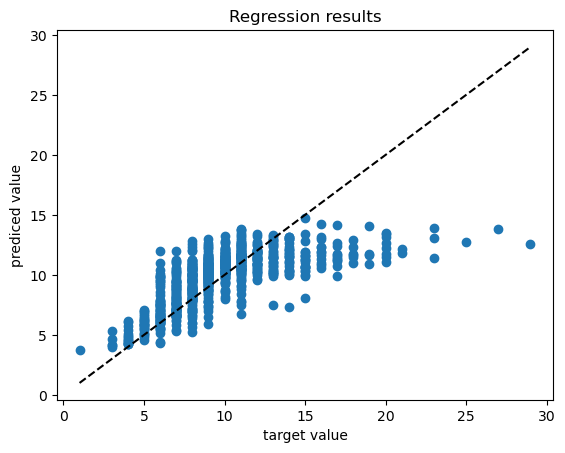

In [52]:
# Resultados de validação
plot_regression(regression_model, device, dataloaders['val'])

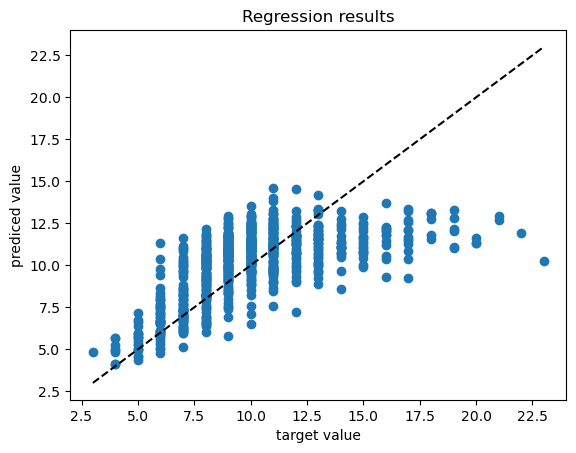

In [53]:
# Resultados dos testes
plot_regression(regression_model, device, dataloaders['test'])

### Olhando para o futuro
Agora que construímos uma base com PyTorch, seremos capazes de realizar muitas tarefas diferentes de aprendizagem de máquina. Primeiro, nos concentraremos no reconhecimento de dígitos manuscritos usando o conjunto de dados MNIST e usaremos esse conjunto de dados para introduzir arquiteturas mais complexas de redes neurais profundas.